In [1]:
import csv
import math
import pandas as pd
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,KFold
from sklearn import preprocessing, svm
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit


# input data
data_input=pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/mmc3.csv",sep=',')

labels=data_input['Overpotential']#[:,np.newaxis]
features=data_input.drop('Overpotential', axis=1).drop('DOI', axis=1)

X_train,X_test,Y_train,Y_test=train_test_split(features, labels, test_size=0.2,random_state=99) 
reg = GradientBoostingRegressor(alpha=0.75, learning_rate=0.1, loss="squared_error", max_depth=8, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7000000000000001)
reg.fit(X_train, Y_train)

Y_pred =  reg.predict(X_test)
Y_pred_2 =  reg.predict(X_train)

result1=pd.DataFrame(columns=['y_test','y_pred'])
result2=pd.DataFrame(columns=['y_train','y_train_pred'])
result1['y_test']=Y_test
result1['y_pred']=Y_pred
result2['y_train']=Y_train
result2['y_train_pred']=Y_pred_2
print("Train Accuracy : %.4g" % sk.metrics.r2_score(Y_train, Y_pred_2))
print("Test Accuracy : %.4g" % sk.metrics.r2_score(Y_test, Y_pred))
print("Train Accuracy MAE: %.4g" % sk.metrics.mean_absolute_error(Y_train, Y_pred_2))
print("Test Accuracy MAE: %.4g" % sk.metrics.mean_absolute_error(Y_test, Y_pred))
print("Train Accuracy mse: %.4g" % sk.metrics.mean_squared_error(Y_train, Y_pred_2))
print("Test Accuracy mse: %.4g" % sk.metrics.mean_squared_error(Y_test, Y_pred))

Train Accuracy : 0.9999
Test Accuracy : 0.9724
Train Accuracy MAE: 0.9879
Test Accuracy MAE: 13.53
Train Accuracy mse: 2.21
Test Accuracy mse: 329.7


In [2]:
result1

,y_test,y_pred
372,661.0,622.717974
288,143.5,133.808744
37,69.0,53.093116
170,50.0,53.199308
7,92.0,58.834782
...,...,...
180,17.4,48.682475
361,87.0,81.069978
186,71.0,74.075438
317,61.0,53.020670


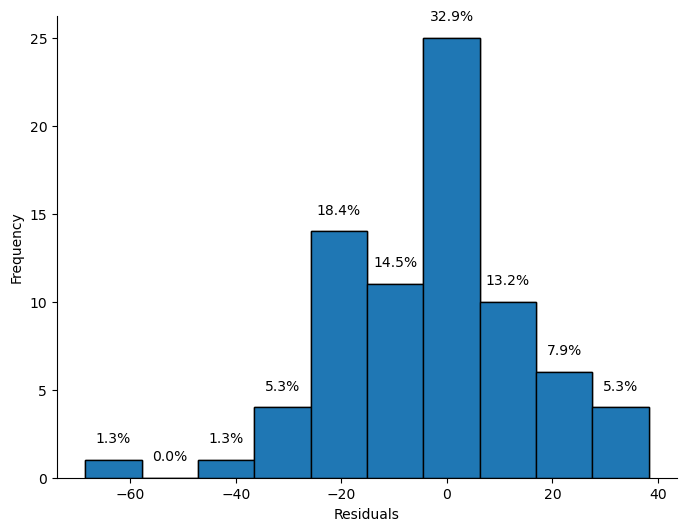

In [3]:
result1['residuals'] = result1['y_test'] - result1['y_pred']

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(result1['residuals'], bins=10, edgecolor='black', color='blue')

# Get histogram counts and bin edges
counts, bins, _ = plt.hist(result1['residuals'], bins=10, edgecolor='black')

# Calculate percentages
percentages = [f'{count / len(result1) * 100:.1f}%' for count in counts]

# Annotate each bin with its percentage
for i, count in enumerate(counts):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, count + 1, percentages[i], ha='center')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('histogram_residuals_GBR.pdf')
plt.show()

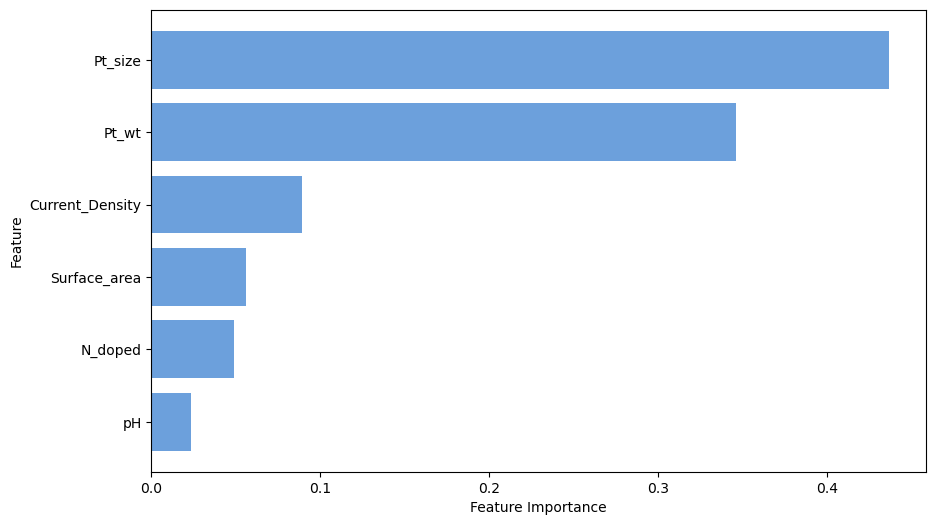

In [16]:
importances = reg.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6CA0DC')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig('feature_importances_xgb.jpg', bbox_inches='tight', transparent=True, dpi=900)
plt.show()

In [17]:
import dalex as dx

In [18]:
exp_GB  = dx.Explainer(reg, features, labels, 
                    label = "Overpotential (mV)")

Preparation of a new explainer is initiated

  -> data              : 379 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 379 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : Overpotential (mV)
  -> predict function  : <function yhat_default at 0x7fd8e00ba710> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.77, mean = 1.06e+02, max = 7.66e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -69.8, mean = -0.505, max = 35.5
  -> model_info        : package sklearn

A new explainer has been created!


In [20]:
cp_exp_cat  = exp_GB.predict_profile(X_test)
cp_exp_cat.result

Calculating ceteris paribus: 100%|██████████| 6/6 [00:00<00:00, 31.79it/s]


,Pt_wt,Pt_size,Surface_area,N_doped,pH,Current_Density,_original_,_yhat_,_vname_,_ids_,_label_
372,0.000,0.00,461.0,11.62,0.3,20.0,0.0,630.353715,Pt_wt,372,Overpotential (mV)
372,0.100,0.00,461.0,11.62,0.3,20.0,0.0,410.744757,Pt_wt,372,Overpotential (mV)
372,0.180,0.00,461.0,11.62,0.3,20.0,0.0,408.794421,Pt_wt,372,Overpotential (mV)
372,0.250,0.00,461.0,11.62,0.3,20.0,0.0,383.504593,Pt_wt,372,Overpotential (mV)
372,0.314,0.00,461.0,11.62,0.3,20.0,0.0,372.845578,Pt_wt,372,Overpotential (mV)
...,...,...,...,...,...,...,...,...,...,...,...
281,0.500,0.35,282.0,12.08,0.3,192.4,10.0,208.817850,Current_Density,281,Overpotential (mV)
281,0.500,0.35,282.0,12.08,0.3,194.3,10.0,208.817850,Current_Density,281,Overpotential (mV)
281,0.500,0.35,282.0,12.08,0.3,196.2,10.0,208.817850,Current_Density,281,Overpotential (mV)
281,0.500,0.35,282.0,12.08,0.3,198.1,10.0,208.817850,Current_Density,281,Overpotential (mV)


In [23]:
import plotly.io as pio
fig_cp_exp_cat_Particle_size = cp_exp_cat.plot(variables=["Pt_size"], show=False)

pio.write_image(fig_cp_exp_cat_Particle_size, "gbr_Particle_size (nm)_plot.pdf")

In [37]:
PH_03_CD_10_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 0.3 CD 10 Dataset.csv", sep=',')
PH_03_CD_20_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 0.3 CD 20 Dataset.csv", sep=',')
PH_03_CD_40_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 0.3 CD 40 Dataset.csv", sep=',')
PH_03_CD_50_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 0.3 CD 50 Dataset.csv", sep=',')
PH_03_CD_100_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 0.3 CD 100 Dataset.csv", sep=',')
PH_14_CD_10_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 14 CD 10 Dataset.csv", sep=',')
PH_14_CD_20_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 14 CD 20 Dataset.csv", sep=',')
PH_14_CD_40_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 14 CD 40 Dataset.csv", sep=',')
PH_14_CD_50_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 14 CD 50 Dataset.csv", sep=',')
PH_14_CD_100_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/PH 14 CD 100 Dataset - Copy.csv", sep=',')

def split_dataframe(df):
    df = df.drop(columns=['Samples'])
    X = df[['Pt_wt', 'Pt_size', 'Surface_area', 'N_doped', 'pH', 'Current_Density']]
    Y = df['Overpotential']
    return X, Y

X_PH_03_CD_10_Test_Data, Y_PH_03_CD_10_Test_Data = split_dataframe(PH_03_CD_10_Test_Data)
X_PH_03_CD_20_Test_Data, Y_PH_03_CD_20_Test_Data = split_dataframe(PH_03_CD_20_Test_Data)
X_PH_03_CD_40_Test_Data, Y_PH_03_CD_40_Test_Data = split_dataframe(PH_03_CD_40_Test_Data)
X_PH_03_CD_50_Test_Data, Y_PH_03_CD_50_Test_Data = split_dataframe(PH_03_CD_50_Test_Data)
X_PH_03_CD_100_Test_Data, Y_PH_03_CD_100_Test_Data = split_dataframe(PH_03_CD_100_Test_Data)
X_PH_14_CD_10_Test_Data, Y_PH_14_CD_10_Test_Data = split_dataframe(PH_14_CD_10_Test_Data)
X_PH_14_CD_20_Test_Data, Y_PH_14_CD_20_Test_Data = split_dataframe(PH_14_CD_20_Test_Data)
X_PH_14_CD_40_Test_Data, Y_PH_14_CD_40_Test_Data = split_dataframe(PH_14_CD_40_Test_Data)
X_PH_14_CD_50_Test_Data, Y_PH_14_CD_50_Test_Data = split_dataframe(PH_14_CD_50_Test_Data)
X_PH_14_CD_100_Test_Data, Y_PH_14_CD_100_Test_Data = split_dataframe(PH_14_CD_100_Test_Data)

In [40]:
y_pred = reg.predict(X_PH_03_CD_10_Test_Data)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PH_03_CD_10_Test_Data
result1['y_pred'] = y_pred

result1

,y_test,y_pred
0,43.0,26.204280
1,38.0,25.544189
2,35.7,48.511784
3,39.0,34.620017
4,36.3,32.961125
